In [2]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
import os
from scipy import signal
from scipy.sparse import linalg
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import save_npz
from numpy import *

## Preparation

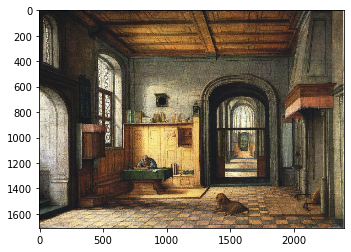

In [3]:
# Feel free to change image
background_img = cv2.cvtColor(cv2.imread('painting.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


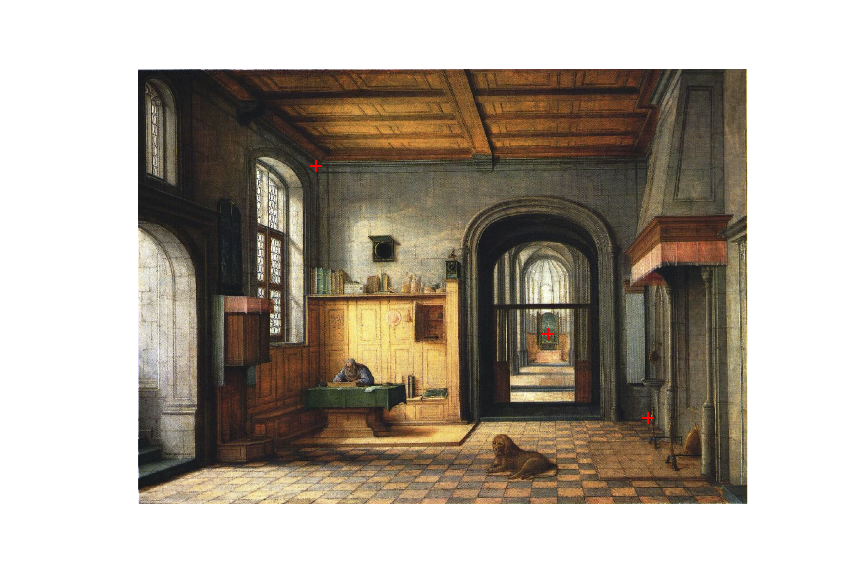

In [13]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread('painting.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

In [14]:

#PLACE FUNCTIONS BELOW###

def saveBackWallImg(img,xs,ys):
    back_wall_image=np.copy(im_src[ys[0]:ys[2],xs[0]:xs[2]])
    back_wall_image=cv2.resize(back_wall_image, (256,256), interpolation = cv2.INTER_AREA)
    cv2.imwrite('backwall.jpeg',back_wall_image)
    return

def getBoxHeight(ys):
    return (ys[2]-ys[0])/float(ys[2]-ys[1])

#https://stackoverflow.com/questions/3252194/numpy-and-line-intersections
def perp(a) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2):
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    numOfRows=2*len(pts1)
    numOfCols=9
    A=np.zeros((numOfRows,numOfCols))
    
    for i in range(0,len(pts1)):
        (aX,aY) = pts1[i,:]
        (bX,bY) = pts2[i,:]
        
        A[2*i] = np.array([-aX,-aY,-1,0,0,0,bX*aX,bX*aY,bX])
        A[2*i+1] = np.array([0,0,0,-aX,-aY,-1,bY*aX,bY*aY,bY])
    
    U,s,v = np.linalg.svd(A)
    
    H = np.eye(3)
    
    H = np.reshape(v[-1], (3,3))
    H = np.divide(H,H[2,2])
    return H

####################################################
####################################################
##### P0 ################################# P1 ######
####################################################
####################################################
################## P2 ############# P3 #############
####################################################
####################################################
####################################################
####################################################
####################################################
################## P4 ############# P5 #############
####################################################
####################################################
##### P6 ################################# P7 ######
####################################################
####################################################
def getBoundingBox3DCoords(xs,ys,pxl_to_d_ratio,box_height,focal):
    P0=((xs[0]-xs[1])*pxl_to_d_ratio,box_height,0)
    P1=((xs[2]-xs[1])*pxl_to_d_ratio,box_height,0)
    P2=((xs[0]-xs[1])*pxl_to_d_ratio,box_height,-focal/float(ys[2]-ys[1]))
    P3=((xs[2]-xs[1])*pxl_to_d_ratio,box_height,-focal/float(ys[2]-ys[1]))
    P4=((xs[0]-xs[1])*pxl_to_d_ratio,0,-focal/float(ys[2]-ys[1]))
    P5=((xs[2]-xs[1])*pxl_to_d_ratio,0,-focal/float(ys[2]-ys[1]))
    P6=((xs[0]-xs[1])*pxl_to_d_ratio,0,0)
    P7=((xs[2]-xs[1])*pxl_to_d_ratio,0,0)
    return [P0,P1,P2,P3,P4,P5,P6,P7]

def getHomographyOfRightWall(img,xs,ys):
    w=img.shape[1]
    h=img.shape[0]
    
    #two points that determine P3 --> P1 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[2],abs(h-ys[0])])

    #two points that determine P7 --> P1 line
    P2 = np.array([w,0])
    P3 = np.array([w,h])
    
    #pixel coordinate of P3, P5
    P00=np.array([ys[0],xs[2]])
    P10=np.array([ys[2],xs[2]])
    
    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P1
    P01=np.array([intersectionP[1],intersectionP[0]])
    
    #two points that determine P5 --> P7 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[2],abs(h-ys[2])])

    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P7
    P11=np.array([intersectionP[1],intersectionP[0]])
    
    uvCoords=np.array([[0.,0.],[256.,0.],[0.,256.],[256.,256.]])
    picCoords=np.array([[P00[1],P00[0]],[P01[1],P01[0]],[P10[1],P10[0]],[P11[1],P11[0]]])
    H,status=cv2.findHomography(picCoords,uvCoords)
    return H

def getHomographyOfLeftWall(img,xs,ys):
    w=img.shape[1]
    h=img.shape[0]
    
    #two points that determine P2 --> P0 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[0],abs(h-ys[0])])

    #two points that determine P6 --> P0 line
    P2 = np.array([0,0])
    P3 = np.array([0,h])
    
    #pixel coordinate of P2, P4
    P01=np.array([ys[0],xs[0]])
    P11=np.array([ys[2],xs[0]])
    
    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P1
    P00=np.array([intersectionP[1],intersectionP[0]])
    
    #two points that determine P4 --> P6 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[0],abs(h-ys[2])])

    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P6
    P10=np.array([intersectionP[1],intersectionP[0]])
    
    uvCoords=np.array([[0.,0.],[256.,0.],[0.,256.],[256.,256.]])
    picCoords=np.array([[P00[1],P00[0]],[P01[1],P01[0]],[P10[1],P10[0]],[P11[1],P11[0]]])
    H,status=cv2.findHomography(picCoords,uvCoords)
    return H

def getHomographyOfBottomWall(img,xs,ys):
    w=img.shape[1]
    h=img.shape[0]
    
    #two points that determine P5 --> P7 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[2],abs(h-ys[2])])

    #two points that determine P6 --> P7 line
    P2 = np.array([0,0])
    P3 = np.array([w,0])
    
    #pixel coordinate of P2, P4
    P00=np.array([ys[2],xs[0]])
    P01=np.array([ys[2],xs[2]])
    
    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P1
    P11=np.array([intersectionP[1],intersectionP[0]])
    
    #two points that determine P4 --> P6 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[0],abs(h-ys[2])])

    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P6
    P10=np.array([intersectionP[1],intersectionP[0]])
    
    uvCoords=np.array([[0.,0.],[256.,0.],[0.,256.],[256.,256.]])
    picCoords=np.array([[P00[1],P00[0]],[P01[1],P01[0]],[P10[1],P10[0]],[P11[1],P11[0]]])
    H,status=cv2.findHomography(picCoords,uvCoords)
    return H

def getHomographyOfTopWall(img,xs,ys):
    w=img.shape[1]
    h=img.shape[0]
    
    #two points that determine P2 --> P0 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[0],abs(h-ys[0])])

    #two points that determine P0 --> P1 line
    P2 = np.array([0,h])
    P3 = np.array([w,h])
    
    #pixel coordinate of P2, P3
    P10=np.array([ys[0],xs[0]])
    P11=np.array([ys[0],xs[2]])
    
    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P1
    P00=np.array([intersectionP[1],intersectionP[0]])
    
    #two points that determine P3 --> P1 line
    P0 = np.array([xs[1],abs(h-ys[1])])
    P1 = np.array([xs[2],abs(h-ys[0])])

    intersectionP=seg_intersect(P0,P1,P2,P3)
    intersectionP[1]=h-intersectionP[1]
    #pixel coordinate of P1
    P01=np.array([intersectionP[1],intersectionP[0]])
    
    
    uvCoords=np.array([[0.,0.],[256.,0.],[0.,256.],[256.,256.]])
    picCoords=np.array([[P00[1],P00[0]],[P01[1],P01[0]],[P10[1],P10[0]],[P11[1],P11[0]]])
    H,status=cv2.findHomography(picCoords,uvCoords)
    return H
    
    

"""
P0 --> bottom left
P1 --> bottom right
P2 --> top left
P3 --> top right

nV --> normal vector
"""
def saveObjPlane(P0,P1,P2,P3,planeName):
    nV=["0.000000","0.000000","0.000000"]
    if(planeName=="backwall"):
        nV[2]="1.000000"
    elif(planeName=="rightwall"):
        nV[0]="-1.000000"
    elif(planeName=="leftwall"):
        nV[0]="1.000000"
    elif(planeName=="bottomwall"):
        nV[1]="1.000000"
    elif(planeName=="topwall"):
        nV[1]="-1.000000"
    else:
        nV[2]="1.000000"
    
    vertexStrings=[' '.join(["mtllib",planeName+".mtl\no Plane"]),
                   ' '.join(["v",str(P0[0]),str(P0[1]),str(P0[2])]),
                   ' '.join(["v",str(P1[0]),str(P1[1]),str(P1[2])]),
                   ' '.join(["v",str(P2[0]),str(P2[1]),str(P2[2])]),
                   ' '.join(["v",str(P3[0]),str(P3[1]),str(P3[2])]),
                   ' '.join(["vt","0.000000","0.000000"]),
                   ' '.join(["vt","1.000000","0.000000"]),
                   ' '.join(["vt","0.000000","1.000000"]),
                   ' '.join(["vt","1.000000","1.000000"]),
                   ' '.join(["vn",nV[0],nV[1],nV[2]]),
                   ' '.join(["usemtl",planeName+"Material"]),
                   ' '.join(["s","off"]),
                   ' '.join(["f","1/1/1","2/2/1","4/4/1","3/3/1"]),
                  ]
    vertexStrings='\n'.join(vertexStrings)
    mltStrings=[' '.join(["newmtl",planeName+"Material"]),
                   ' '.join(["map_Kd",planeName+".jpeg"]),
                   ' '.join(["map_Ka",planeName+".jpeg"]),
                  ]
    mtlStrings='\n'.join(mltStrings)
    file = open(planeName+'.obj', 'w')
    file.write(vertexStrings)
    file.close()
    file = open(planeName+'.mtl', 'w')
    file.write(mtlStrings)
    file.close()


[699, 1612, 2005]
[379, 1040, 1370]


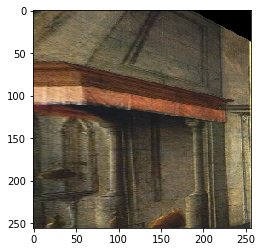

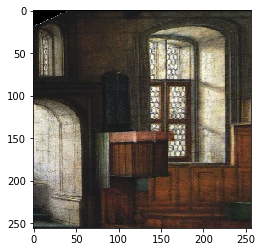

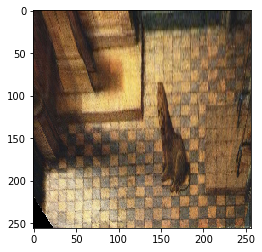

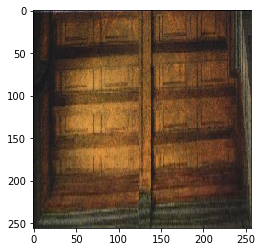

In [15]:
xs = mask_coords[0]
ys = mask_coords[1]
xs = [int(i) for i in xs]
ys = [int(i) for i in ys]

%matplotlib inline
import matplotlib.pyplot as plt
print(xs)
print(ys)
im_src = cv2.imread("painting.JPG")
# focal=1.4*(max(im_src.shape[0],im_src.shape[1]))

#constants
focal=1000
camera_height=1
camera_pos=(0,1,0)

box_height=getBoxHeight(ys)
pxl_to_d_ratio=float(box_height)/(ys[2]-ys[0])


coords3D=getBoundingBox3DCoords(xs,ys,pxl_to_d_ratio,box_height,focal)
saveObjPlane(coords3D[4],coords3D[5],coords3D[2],coords3D[3],'backwall')
saveObjPlane(coords3D[6],coords3D[4],coords3D[0],coords3D[2],'leftwall')
saveObjPlane(coords3D[5],coords3D[7],coords3D[3],coords3D[1],'rightwall')
saveObjPlane(coords3D[6],coords3D[7],coords3D[4],coords3D[5],'bottomwall')
saveObjPlane(coords3D[2],coords3D[3],coords3D[0],coords3D[1],'topwall')

saveBackWallImg(im_src,xs,ys)

im_src = cv2.imread("painting.JPG")
H=getHomographyOfRightWall(im_src,xs,ys)
im_dst = cv2.cvtColor(cv2.warpPerspective(im_src,H, (256,256)),cv2.COLOR_BGR2RGB)
cv2.imwrite('rightwall.jpeg',cv2.cvtColor(im_dst,cv2.COLOR_RGB2BGR))
plt.figure()
plt.imshow(im_dst)

H=getHomographyOfLeftWall(im_src,xs,ys)
im_dst = cv2.cvtColor(cv2.warpPerspective(im_src,H, (256,256)),cv2.COLOR_BGR2RGB)
cv2.imwrite('leftwall.jpeg',cv2.cvtColor(im_dst,cv2.COLOR_RGB2BGR))
plt.figure()
plt.imshow(im_dst)

H=getHomographyOfBottomWall(im_src,xs,ys)
im_dst = cv2.cvtColor(cv2.warpPerspective(im_src,H, (256,256)),cv2.COLOR_BGR2RGB)
cv2.imwrite('bottomwall.jpeg',cv2.cvtColor(im_dst,cv2.COLOR_RGB2BGR))
plt.figure()
plt.imshow(im_dst)

H=getHomographyOfTopWall(im_src,xs,ys)
im_dst = cv2.cvtColor(cv2.warpPerspective(im_src,H, (256,256)),cv2.COLOR_BGR2RGB)
cv2.imwrite('topwall.jpeg',cv2.cvtColor(im_dst,cv2.COLOR_RGB2BGR))
plt.figure()
plt.imshow(im_dst)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


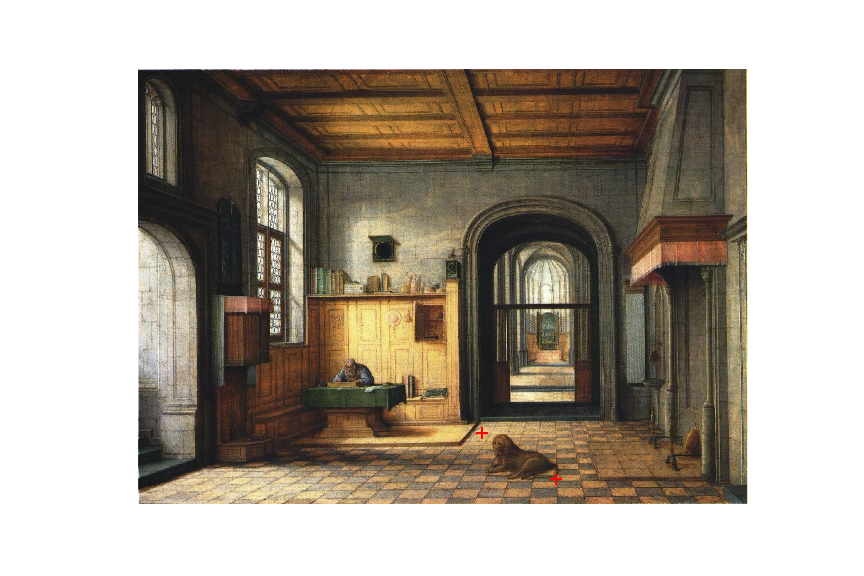

In [53]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread('painting.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_fg_coords = specify_mask(object_img)

In [54]:
xs = mask_fg_coords[0]
ys = mask_fg_coords[1]
xs = [int(i) for i in xs]
ys = [int(i) for i in ys]
print(xs)
print(ys)

xs_box = mask_coords[0]
ys_box = mask_coords[1]
xs_box = [int(i) for i in xs_box]
ys_box = [int(i) for i in ys_box]
print(xs_box)
print(ys_box)

[1352, 1643]
[1433, 1613]
[699, 1612, 2005]
[379, 1040, 1370]


If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


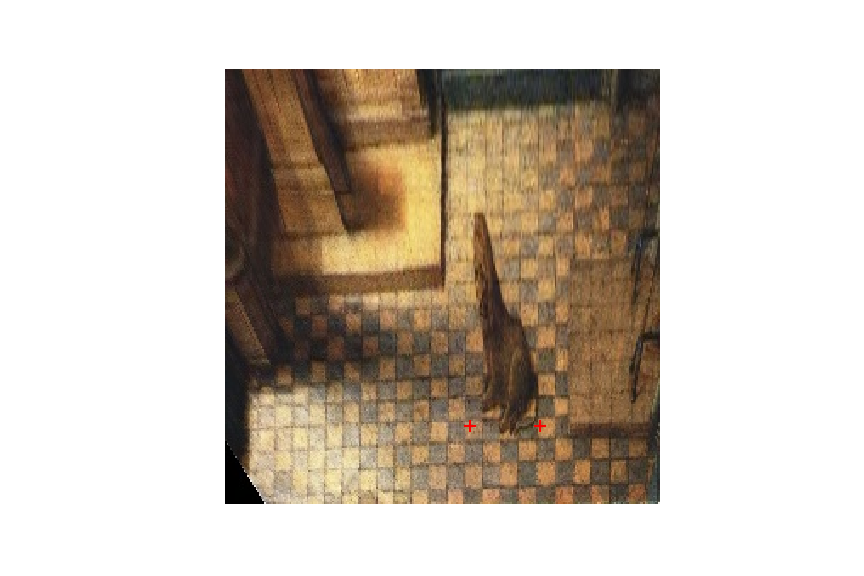

In [59]:
#select ground points
object_img = cv2.cvtColor(cv2.imread('bottomwall.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_fg_ground_coords = specify_mask(object_img)

In [62]:
xs_fg_ground = mask_fg_ground_coords[0]
ys_fg_ground = mask_fg_ground_coords[1]
xs_fg_ground = [int(i) for i in xs_fg_ground]
ys_fg_ground = [int(i) for i in ys_fg_ground]
print(xs_fg_ground)
print(ys_fg_ground)

[143, 184]
[209, 209]


In [110]:
picCoords=np.array([[0.,0.],[256.,0.],[0.,256.],[256.,256.]])
worldCoords=np.array([[coords3D[4][0],coords3D[4][2]],[coords3D[5][0],coords3D[5][2]],[coords3D[6][0],coords3D[6][2]],[coords3D[7][0],coords3D[7][2]]])
unProjectionMatrix=cv2.findHomography(picCoords,worldCoords)

threeDCoordDepthLeft=unProjectionMatrix[0].dot(np.array([xs_fg_ground[0],ys_fg_ground[0],1.]))
threeDCoordDepthRight=unProjectionMatrix[0].dot(np.array([xs_fg_ground[1],ys_fg_ground[1],1.]))


#detting depth
fg_depth=threeDCoordDepthLeft[1]

hi=(ys[1]-ys[0])*pxl_to_d_ratio
print(hi)

#getting bottom right
bottomRight=np.array([threeDCoordDepthRight[0],0,threeDCoordDepthRight[1]])
#getting bottom left
bottonLeft=np.array([threeDCoordDepthLeft[0],0,threeDCoordDepthLeft[1]])
#getting top right
topRight=np.array([threeDCoordDepthRight[0],hi,threeDCoordDepthRight[1]])
#getting top left
topLeft=np.array([threeDCoordDepthLeft[0],hi,threeDCoordDepthLeft[1]])

saveObjPlane(bottonLeft,bottomRight,topLeft,topRight,'fgobj')

0.5454545454545454


In [111]:
def savePlaneImg(img,xs,ys,planeName):
    back_wall_image=np.copy(im_src[ys[0]:ys[1],xs[0]:xs[1]])
    back_wall_image=cv2.resize(back_wall_image, (256,256), interpolation = cv2.INTER_AREA)
    cv2.imwrite(planeName+'.jpeg',back_wall_image)
    return

In [112]:
savePlaneImg(im_src,xs,ys,'fgobj')

In [ ]:
#getting height

In [30]:
hi=(ys[1]-ys[0])*pxl_to_d_ratio


0.5696969696969697
-3.0303030303030307


In [40]:
j=((ys_box[2]-ys_box[1])/(ys[1]-ys_box[1]))*((ys[0]-ys_box[1])/(ys[1]-ys_box[1]))
print(j)
di=j*focal/(ys[0]-ys[1])
print(di)

0.38419722657534494
-2.043602269017792
